In [1]:
import pandas as pd
from pathlib import Path

In [2]:
!pip install -q efficientnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [efficientnet]


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import os, cv2, re, random, time, zipfile, gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import layers, models, optimizers
#from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam
import efficientnet.tfkeras as efn


2025-08-18 19:51:22.216168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755546682.229121       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755546682.233945       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 19:51:22.249809: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.11/dist-packages/keras/api/preprocessing/image/__init__.py)

In [4]:
PATH = '/kaggle/input/dogs-vs-cats-redux-kernels-edition/'
train_image_path = os.path.join(PATH, 'train.zip')
test_image_path = os.path.join(PATH, 'test.zip')

with zipfile.ZipFile(train_image_path,"r") as z:
    z.extractall("./data") # target dir
    z.close()
    
with zipfile.ZipFile(test_image_path,"r") as z:
    z.extractall("./data")
    z.close()
#zip_ref.close()


In [5]:
start = time.time() 

TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]


FileNotFoundError: [Errno 2] No such file or directory: './data/train/'

In [6]:
def txt_dig(text):
    '''输入字符串，如果是数字则输出数字，如果不是则输出原本字符串'''
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''输入字符串，将数字与文字分隔开，将数字串转化为int'''
    return [ txt_dig(c) for c in re.split('(\d+)', text) ]


In [7]:
train_images.sort(key=natural_keys) # 依据编号进行重新排序
test_images.sort(key=natural_keys)

train_images = train_images[0:1300] +  train_images[23700:25000]  #抽样
random.seed(558)
random.shuffle(train_images)


NameError: name 'train_images' is not defined

In [8]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
x = []
for img in train_images:
    x.append(cv2.resize(cv2.imread(img), 
                        (IMG_WIDTH, IMG_HEIGHT), 
                        interpolation=cv2.INTER_CUBIC))
    
test = []
for img in test_images:
    test.append(cv2.resize(cv2.imread(img), 
                        (IMG_WIDTH, IMG_HEIGHT), 
                        interpolation=cv2.INTER_CUBIC))
    
print('The shape of train data is {}'.format(np.array(x).shape))
print('The shape of test data is {}'.format(np.array(test).shape))

# extract label vector
plt.rcParams['figure.facecolor'] = 'white'
y = []
for i in train_images:
    if 'dog' in i:
        y.append(1)
    elif 'cat' in i:
        y.append(0)
len(y)

x = np.array(x)
y = np.array(y)
test = np.array(test)
sns.countplot(y)


NameError: name 'train_images' is not defined

NameError: name 'train_images' is not defined

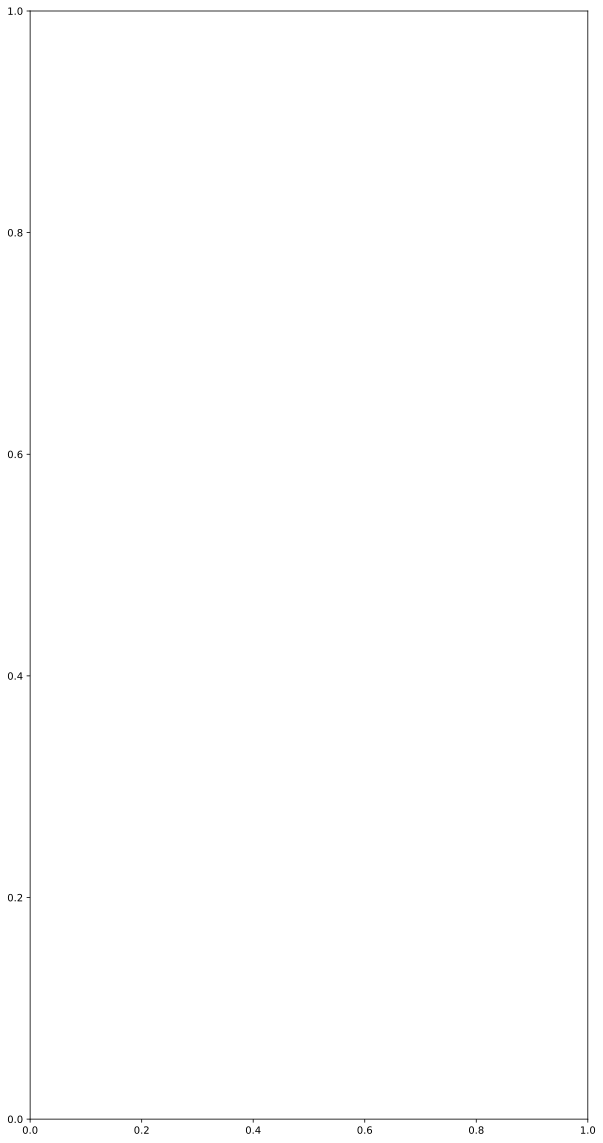

In [9]:
random.seed(558)
plt.subplots(facecolor='white',figsize=(10,20))
sample = random.choice(train_images)
image = load_img(sample)
plt.subplot(131)
plt.imshow(image)

sample = random.choice(train_images)
image = load_img(sample)
plt.subplot(132)
plt.imshow(image)

sample = random.choice(train_images)
image = load_img(sample)
plt.subplot(133)
plt.imshow(image)


TypeError: list indices must be integers or slices, not tuple

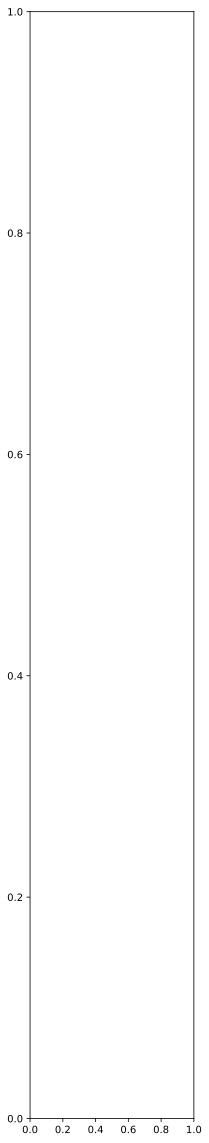

In [10]:
plt.subplots(facecolor='white',figsize=(10,20))
plt.subplot(131)
plt.imshow(cv2.cvtColor(x[1024,:,:,:], cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.imshow(cv2.cvtColor(x[546,:,:,:], cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.imshow(cv2.cvtColor(x[742,:,:,:], cv2.COLOR_BGR2RGB))


In [11]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2020)


NameError: name 'y' is not defined

In [12]:
model = models.Sequential()


efnModel = efn.EfficientNetB7(weights = 'imagenet', 
                       input_shape = (IMG_WIDTH, IMG_HEIGHT,3), 
                       include_top = False)
model.add(efnModel)
model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Dense(512, activation= 'relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

# decay is included for backward compatibility to allow time inverse decay of lr
opt1 = RMSprop(lr=1e-5, decay=1e-6)
opt2 = Adam(lr=0.006) 

model.compile(loss='binary_crossentropy',
              optimizer = opt1, 
              metrics = ['accuracy'])

model.summary()


NameError: name 'models' is not defined

In [13]:
datagen = ImageDataGenerator(
            rescale=1. / 255,            # 将数据放缩到0-1范围内
            rotation_range=40,           # 图像随机旋转的角度范围
            width_shift_range=0.2,       # 图像在水平方向上平移的范围
            height_shift_range=0.2,      # 图像在垂直方向上平移的范围
            shear_range=0.2,             # 随机错切变换的角度
            zoom_range=0.2,              # 图像随机缩放的范围
            horizontal_flip=True,        # 随机将一半图像水平翻转
            fill_mode='nearest')         # 填充新创建像素的方法

val_datagen = ImageDataGenerator(rescale=1./255)


NameError: name 'ImageDataGenerator' is not defined

In [14]:
def plot_gened(train_images,seed=320):
    '''plot pictures after processing
    '''
    df = pd.DataFrame({'filename': train_images})
    np.random.seed(seed)
    vis_df = df.sample(n=1).reset_index(drop=True)
    vis_df['category'] = '0'
#vis_df
    vis_gen = ImageDataGenerator(
            rescale=1. / 255,             # 将数据放缩到0-1范围内
            rotation_range=40,            # 图像随机旋转的角度范围
            width_shift_range=0.2,        # 图像在水平方向上平移的范围
            height_shift_range=0.2,       # 图像在垂直方向上平移的范围
            shear_range=0.2,              # 随机错切变换的角度
            zoom_range=0.2,               # 图像随机缩放的范围
            horizontal_flip=True,         # 随机将一半图像水平翻转
            fill_mode='nearest')          # 填充新创建像素的方法

    vis_gen0 = vis_gen.flow_from_dataframe(vis_df,
                                       x_col='filename',
                                       y_col='category',
                                       target_size=(IMG_WIDTH, IMG_HEIGHT),
                                       batch_size = 16)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.figure(figsize=(8, 8))
    for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in vis_gen0:
            image = X_batch[0]
            plt.imshow(image)
            break
    plt.tight_layout()
    plt.show()
    
plot_gened(train_images)    


NameError: name 'train_images' is not defined

In [15]:
BATCH_SIZE = 16
datagen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_datagen = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)

earlystop1 = EarlyStopping(patience=5)
earlystop2 = ReduceLROnPlateau(monitor = 'val_accuracy', min_lr = 0.001, 
                               patience = 5, mode = 'min', 
                               verbose = 1)

history = model.fit(datagen, 
                    steps_per_epoch=45,
                    epochs=20,
                    validation_data=val_datagen,
                    callbacks=[earlystop1, earlystop2],
                    validation_steps=25)

#print(np.ceil(len(x_train)/BATCH_SIZE))
#print(np.ceil(len(x_val)/BATCH_SIZE))
#model.save('dogs_cats_efficientnetb7.h5')


NameError: name 'datagen' is not defined

In [16]:
plt.rcParams['figure.facecolor'] = 'white'
model_loss = pd.DataFrame(history.history)
model_loss.head()
model_loss[['accuracy','val_accuracy']].plot(ylim=[0.4,0.8]);
model_loss[['loss','val_loss']].plot(ylim=[0.5,1]);


NameError: name 'history' is not defined

In [17]:
val_preds = model.predict(val_datagen, 
                          verbose=1, 
                          steps=np.ceil(len(x_val)/BATCH_SIZE))
print(np.ceil(len(x_val)/BATCH_SIZE))
print('Out of Fold log loss is {:.5}'.format(log_loss(y_val, val_preds.ravel())))


NameError: name 'model' is not defined

In [18]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = test_datagen.flow(np.array(test), batch_size=BATCH_SIZE)
test_pred = model.predict(test_datagen, 
                          verbose=1, 
                          steps=np.ceil(len(test)/BATCH_SIZE))
print(np.ceil(len(test)/BATCH_SIZE))
# test_pred.ravel().mean()
# results = np.where(test_pred.ravel()>0.5,1,0) 


NameError: name 'ImageDataGenerator' is not defined

In [19]:
submission = pd.DataFrame({'id': range(1, len(test_images) + 1), 'label': test_pred.ravel()})
submission.to_csv('submission.csv', index = False)
print('This program costs {:.2f} seconds'.format(time.time()-start))
submission


NameError: name 'test_images' is not defined

In [20]:
!rm -rf /kaggle/working/data/ # remove all imgs unzipped at /data folder
